In [1]:
import io
from diffusers import StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_all_in_all import StableDiffusionPipelineAll
from diffusers.utils import is_xformers_available
import os
import time
import torch
import inspect
import copy
import accelerate
from PIL import Image
from accelerate.utils import set_module_tensor_to_device
from transformers import CLIPTextConfig, AutoTokenizer
from diffusers import UNet2DConditionModel
from safetensors.torch import safe_open
from svdiff_pytorch import UNet2DConditionModelForSVDiff, CLIPTextModelForSVDiff
from diffusers import LMSDiscreteScheduler, DDIMScheduler, PNDMScheduler, DPMSolverMultistepScheduler, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler

SCHEDULER_MAPPING = {
    "ddim": DDIMScheduler,
    "plms": PNDMScheduler,
    "lms": LMSDiscreteScheduler,
    "euler": EulerDiscreteScheduler,
    "euler_ancestral": EulerAncestralDiscreteScheduler,
    "dpm_solver++": DPMSolverMultistepScheduler,
}


def load_unet_for_svdiff(original_model, pretrained_model_name_or_path, spectral_shifts_ckpt=None, device="cuda", init=False, **kwargs):
    """
    https://github.com/huggingface/diffusers/blob/v0.14.0/src/diffusers/models/modeling_utils.py#L541
    """
    config = UNet2DConditionModel.load_config(pretrained_model_name_or_path, **kwargs)
    state_dict = original_model.state_dict()
    with accelerate.init_empty_weights():
        model = UNet2DConditionModelForSVDiff.from_config(config)
    # load pre-trained weights
    param_device = "cpu"
    torch_dtype = kwargs["torch_dtype"] if "torch_dtype" in kwargs else None
    spectral_shifts_weights = {n: torch.zeros(p.shape) for n, p in model.named_parameters() if "delta" in n}
    state_dict.update(spectral_shifts_weights)
    # move the params from meta device to cpu
    missing_keys = set(model.state_dict().keys()) - set(state_dict.keys())
    if len(missing_keys) > 0:
        raise ValueError(
            f"Cannot load {model.__class__.__name__} from {pretrained_model_name_or_path} because the following keys are"
            f" missing: \n {', '.join(missing_keys)}. \n Please make sure to pass"
            " `low_cpu_mem_usage=False` and `device_map=None` if you want to randomely initialize"
            " those weights or else make sure your checkpoint file is correct."
        )
    
    for param_name, param in state_dict.items():
        accepts_dtype = "dtype" in set(inspect.signature(set_module_tensor_to_device).parameters.keys())
        if accepts_dtype:
            set_module_tensor_to_device(model, param_name, param_device, value=param, dtype=torch_dtype)
        else:
            set_module_tensor_to_device(model, param_name, param_device, value=param)

    if spectral_shifts_ckpt:
        if os.path.isdir(spectral_shifts_ckpt):
            spectral_shifts_ckpt = os.path.join(spectral_shifts_ckpt, "spectral_shifts.safetensors")
        assert os.path.exists(spectral_shifts_ckpt)

        with safe_open(spectral_shifts_ckpt, framework="pt", device="cpu") as f:
            for key in f.keys():
                # spectral_shifts_weights[key] = f.get_tensor(key)
                accepts_dtype = "dtype" in set(inspect.signature(set_module_tensor_to_device).parameters.keys())
                if accepts_dtype:
                    set_module_tensor_to_device(model, key, param_device, value=f.get_tensor(key), dtype=torch_dtype)
                else:
                    set_module_tensor_to_device(model, key, param_device, value=f.get_tensor(key))
        print(f"Resumed from {spectral_shifts_ckpt}")
    if "torch_dtype" in kwargs:
        model = model.to(kwargs["torch_dtype"])
    model.register_to_config(_name_or_path=pretrained_model_name_or_path)
    # Set model in evaluation mode to deactivate DropOut modules by default
    model.eval()
    model = model.to(device)
    del original_model
    torch.cuda.empty_cache()
    
    s = time.time()
    for module in model.modules():
        if hasattr(module, "perform_svd"):
            module.perform_svd()
    print(time.time() - s)
    
    model = model.to(device, dtype=torch.float16)
    
    return model


def load_text_encoder_for_svdiff(
        original_model,
        tokenizer,
        pretrained_model_name_or_path,
        spectral_shifts_ckpt=None,
        device="cuda",
        init=False,
        **kwargs
):
    """
    https://github.com/huggingface/diffusers/blob/v0.14.0/src/diffusers/models/modeling_utils.py#L541
    """
    config = CLIPTextConfig.from_pretrained(pretrained_model_name_or_path, **kwargs)
    state_dict = original_model.state_dict()
    with accelerate.init_empty_weights():
        model = CLIPTextModelForSVDiff(config)
    # load pre-trained weights
    param_device = "cpu"
    trained_token_embeds = None
    torch_dtype = kwargs["torch_dtype"] if "torch_dtype" in kwargs else None
    spectral_shifts_weights = {n: torch.zeros(p.shape) for n, p in model.named_parameters() if "delta" in n}
    state_dict.update(spectral_shifts_weights)
    # move the params from meta device to cpu
    missing_keys = set(model.state_dict().keys()) - set(state_dict.keys())
    if len(missing_keys) > 0:
        raise ValueError(
            f"Cannot load {model.__class__.__name__} from {pretrained_model_name_or_path} because the following keys are"
            f" missing: \n {', '.join(missing_keys)}. \n Please make sure to pass"
            " `low_cpu_mem_usage=False` and `device_map=None` if you want to randomely initialize"
            " those weights or else make sure your checkpoint file is correct."
        )

    for param_name, param in state_dict.items():
        accepts_dtype = "dtype" in set(inspect.signature(set_module_tensor_to_device).parameters.keys())
        if accepts_dtype:
            set_module_tensor_to_device(model, param_name, param_device, value=param, dtype=torch_dtype)
        else:
            set_module_tensor_to_device(model, param_name, param_device, value=param)

    if spectral_shifts_ckpt:
        if os.path.isdir(spectral_shifts_ckpt):
            spectral_shifts_ckpt = os.path.join(spectral_shifts_ckpt, "spectral_shifts_te.safetensors")
        # load state dict only if `spectral_shifts_te.safetensors` exists
        if os.path.exists(spectral_shifts_ckpt):
            with safe_open(spectral_shifts_ckpt, framework="pt", device="cpu") as f:
                trained_token_embeds = {}
                for key in f.keys():
                    if key.startswith("modifier_tokens"):
                        print(f"Adding {key} to trained_token_embeds")
                        trained_token_embeds[key.split(".")[1]] = f.get_tensor(key)
                        continue
                    # spectral_shifts_weights[key] = f.get_tensor(key)
                    accepts_dtype = "dtype" in set(inspect.signature(set_module_tensor_to_device).parameters.keys())
                    if accepts_dtype:
                        set_module_tensor_to_device(model, key, param_device, value=f.get_tensor(key),
                                                    dtype=torch_dtype)
                    else:
                        set_module_tensor_to_device(model, key, param_device, value=f.get_tensor(key))
            print(f"Resumed from {spectral_shifts_ckpt}")

    if "torch_dtype" in kwargs:
        model = model.to(kwargs["torch_dtype"])

    # model.register_to_config(_name_or_path=pretrained_model_name_or_path)
    # Set model in evaluation mode to deactivate DropOut modules by default
    model.eval()
    del original_model
    torch.cuda.empty_cache()
    model = model.to(device)
    s = time.time()
    for module in model.modules():
        if hasattr(module, "perform_svd"):
            module.perform_svd()
    print(time.time() - s)
    
    model = model.to(device, dtype=torch.float16)
    
    return model, tokenizer


def load_deltas(model, clip_model, pretrained_model_name_or_path, spectral_shifts_ckpt_dir, device="cuda", **kwargs):
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer", use_fast=False)
    param_device = "cpu"
    torch_dtype = kwargs["torch_dtype"] if "torch_dtype" in kwargs else None
    if not spectral_shifts_ckpt_dir:
        for module in model.modules():
            if hasattr(module, "convert_weight_back"):
                module.reset_deltas()
        for module in clip_model.modules():
            if hasattr(module, "convert_weight_back"):
                moduke.reset_deltas()
        return model, clip_model, toke
    
    spectral_shifts_ckpt = os.path.join(spectral_shifts_ckpt_dir, "spectral_shifts.safetensors")
    assert os.path.exists(spectral_shifts_ckpt)

    with safe_open(spectral_shifts_ckpt, framework="pt", device="cpu") as f:
        for key in f.keys():
            accepts_dtype = "dtype" in set(inspect.signature(set_module_tensor_to_device).parameters.keys())
            if accepts_dtype:
                set_module_tensor_to_device(model, key, param_device, value=f.get_tensor(key), dtype=torch_dtype)
            else:
                set_module_tensor_to_device(model, key, param_device, value=f.get_tensor(key))
    print(f"Resumed UNet from {spectral_shifts_ckpt}")
    
    spectral_shifts_ckpt = os.path.join(spectral_shifts_ckpt_dir, "spectral_shifts_te.safetensors")
    if os.path.exists(spectral_shifts_ckpt):
        with safe_open(spectral_shifts_ckpt, framework="pt", device="cpu") as f:
            trained_token_embeds = {}
            for key in f.keys():
                if key.startswith("modifier_tokens"):
                    print(f"Adding {key} to trained_token_embeds")
                    trained_token_embeds[key.split(".")[1]] = f.get_tensor(key)
                    continue
                accepts_dtype = "dtype" in set(inspect.signature(set_module_tensor_to_device).parameters.keys())
                if accepts_dtype:
                    set_module_tensor_to_device(clip_model, key, param_device, value=f.get_tensor(key), dtype=torch_dtype)
                else:
                    set_module_tensor_to_device(clip_model, key, param_device, value=f.get_tensor(key))
        print(f"Resumed Text Encoder from {spectral_shifts_ckpt}")

    modifier_token_ids = []
    if len(trained_token_embeds) > 0:
        for modifier_token in trained_token_embeds.keys():
            # Add the placeholder token in tokenizer
            num_added_tokens = tokenizer.add_tokens(modifier_token)
            # if num_added_tokens == 0:
                # raise ValueError(f"Token '{modifier_token}' already exists in tokenizer. Use a different one.")

            modifier_token_ids.append(tokenizer.convert_tokens_to_ids(modifier_token))

        # Resize the token embeddings as we are adding new special tokens to the tokenizer
        clip_model.resize_token_embeddings(len(tokenizer))
        token_embeds = clip_model.get_input_embeddings().weight.data
        for modifier_token, modifier_token_id in zip(trained_token_embeds.keys(), modifier_token_ids):
            token_embeds[modifier_token_id] = trained_token_embeds[modifier_token].to(device)
            print(f"Loaded {modifier_token_id} token embedding from previous session.")
    s = time.time()
    for module in model.modules():
        if hasattr(module, "convert_weight_back"):
            module.converted_weight_check = False
    print(time.time() - s)        

    return model.to(device), clip_model.to(device), tokenizer


class StableDiffusion:
    def __init__(self, enable_xformers_memory_efficient_attention=True, scheduler="ddim"):
        self.device = "cuda:0"
        self.scheduler = scheduler
        self.pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
        self.pipe, self.base_tokenizer = self.init_modules()
        self.last_delta_ckpt = None
        try:
            if enable_xformers_memory_efficient_attention:
                assert is_xformers_available()
                self.pipe.enable_xformers_memory_efficient_attention()
                print("Using xformers!")
        except Exception as e:
            print(e)
            
    def init_modules(self):
        # scheduler = SCHEDULER_MAPPING[self.scheduler].from_pretrained(self.pretrained_model_name_or_path, subfolder="scheduler")
        scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
        print(f"Using scheduler {scheduler}")
        pipe = StableDiffusionPipelineAll.from_pretrained(self.pretrained_model_name_or_path, scheduler=scheduler, torch_type=torch.float16, revision="fp16", requires_safety_checker=False, safety_checker=None, feature_extractor=None).to(self.device)
        pipe.unet = load_unet_for_svdiff(pipe.unet, self.pretrained_model_name_or_path, device=self.device, subfolder="unet", low_cpu_mem_usage=True)
        pipe.text_encoder, pipe.tokenizer = load_text_encoder_for_svdiff(pipe.text_encoder, pipe.tokenizer, self.pretrained_model_name_or_path, device=self.device, subfolder="text_encoder")
        return pipe, copy.deepcopy(pipe.tokenizer)

    def generate(self, prompt, image=None, mask=None, suggestion_count=1, num_inference_steps=50, guidance_steps=0.4, guidance_scale=7.5, width=512, height=512, inpaint=False, img2img=False, strength=0.8, delta_ckpt=None, seed=42):
        with torch.no_grad():
            tic = time.time()
            if delta_ckpt != self.last_delta_ckpt:
                print(f"Loading {delta_ckpt}.")
                self.pipe.unet, self.pipe.text_encoder, self.pipe.tokenizer = load_deltas(self.pipe.unet, self.pipe.text_encoder, self.pretrained_model_name_or_path, delta_ckpt, device=self.device)
                self.last_delta_ckpt = delta_ckpt
                print("Done loading.")
            image_list = []
            tic = time.time()

            with torch.autocast("cuda"), torch.inference_mode():
                if seed:
                    generator = torch.Generator("cuda").manual_seed(seed)
                else:
                    generator = None
                images = self.pipe(
                    prompt,
                    image=image,
                    mask_image=mask,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    guidance_steps=guidance_steps,
                    num_images_per_prompt=suggestion_count,
                    height=height,
                    width=width,
                    inpaint=inpaint,
                    img2img=img2img,
                    strength=strength,
                    generator=generator,
                ).images

            toc = time.time()
            print(f"Took {round(toc - tic, 2)} seconds")
            return images

            image_output = []
            for image in images:
                with io.BytesIO() as buf:
                    image.save(buf, format="PNG")
                    image_output.append(buf.getvalue())
            return image_output


/admin/home-dome/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/admin/home-dome/anaconda3/envs/control/lib/python3.8/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [2]:
pipe = StableDiffusion()

Using scheduler LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.16.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "trained_betas": null
}



text_encoder/model.safetensors not found
Keyword arguments {'torch_type': torch.float16} are not expected by StableDiffusionPipelineAll and will be ignored.


20.478835582733154
3.9885449409484863
Using xformers!


Using 30


 64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                | 32/50 [00:03<00:01, 11.32it/s]

Removing cfg from prompts
torch.Size([8, 77, 768])
torch.Size([4, 77, 768])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.19it/s]


Took 4.71 seconds


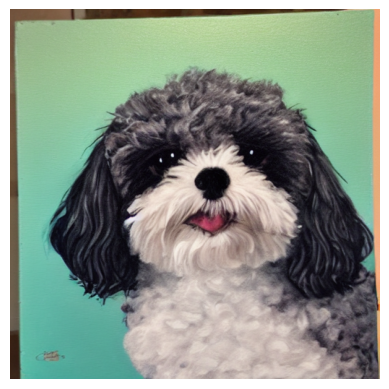

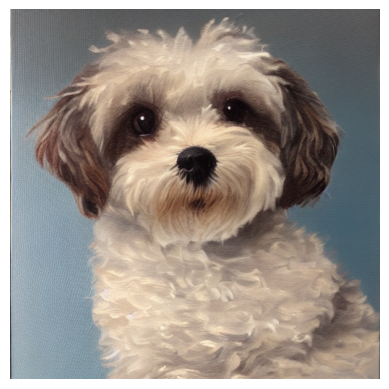

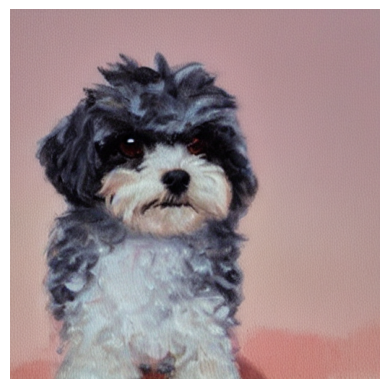

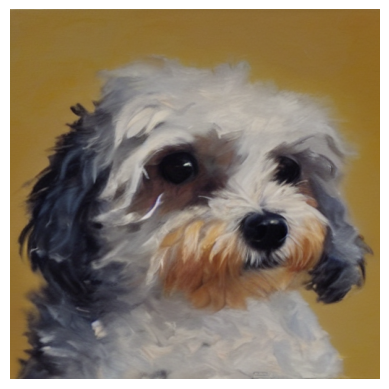

In [8]:
seed = None
delta_ckpt = "/fsx/mas/sd/SVDiff-pytorch/training/output/checkpoint-1600"
# delta_ckpt = "/fsx/mas/sd/custom-svdiff/output/results/piccolo-all/checkpoint-1600"
# delta_ckpt = None
images = pipe.generate("a beautiful oil painting of dog <new1>", 
                       suggestion_count=4, delta_ckpt=delta_ckpt, 
                       guidance_scale=8, guidance_steps=0.6, seed=seed,
                       image=None, mask=None, img2img=False, inpaint=False, strength=0.5,
                      )
import matplotlib.pyplot as plt
for img in images:
    plt.figure()
    plt.axis("off")
    plt.imshow(img)

In [19]:
from PIL import Image
image = Image.open("fernando.jpg").resize((512,512))
mask = Image.open("mask.png").resize((512,512))

/fsx/mas/sd/custom-svdiff/inference/diffusers_all/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_all_in_all.py:733: FutureWarning: You have passed 4 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


Using 20


 49%|██████████████████████████████████████████████████████████████▌                                                                 | 22/45 [00:02<00:01, 11.57it/s]

Removing cfg from prompts
torch.Size([8, 77, 768])
torch.Size([4, 77, 768])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:03<00:00, 11.98it/s]


4.043828725814819


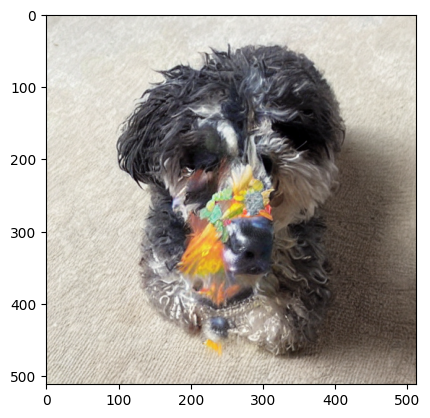

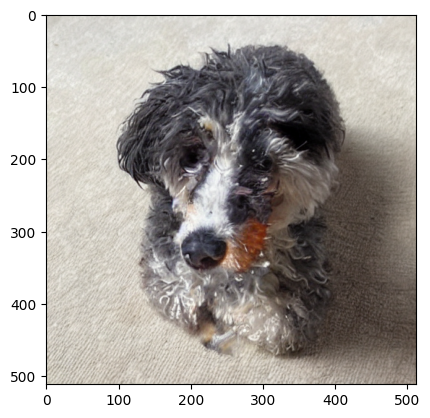

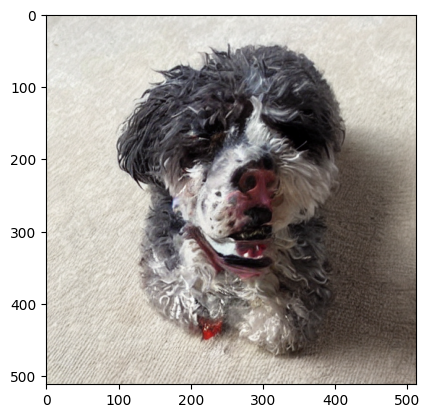

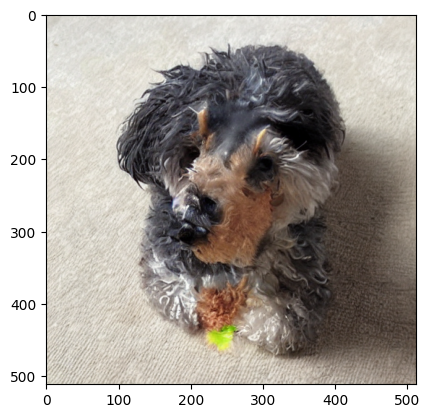

In [6]:
generator = torch.Generator("cuda").manual_seed(42)
caption = "oil on canvas painting of a dog"
with torch.autocast("cuda"), torch.inference_mode():
    s = time.time()
    images = pipe(prompt=caption, guidance_steps=0.4, generator=generator, num_images_per_prompt=4, image=image, mask_image=mask, inpaint=True, img2img=False, strength=0.9).images
    print(time.time() - s)
import matplotlib.pyplot as plt
for img in images:
    plt.figure()
    plt.imshow(img)